- Use ``SequenceDNN_Regression``
    - `num_filters=[100, 100, 100]`
    - `conv_width=[15, 15, 15]`
    - `pool_width=20`

In [2]:
from dragonn import models
from dragonn.plot import add_letters_to_axis

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
key_to_seq = OrderedDict()

with open("../../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        
        # TODO: Figure out if this is an OK thing to do. 'N' basically means the 
        # sequencing software couldn't figure out what the base was...?
        if "N" in seq:
            warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
            seq = seq.replace("N", "A")
        
        assert key not in key_to_seq
        key_to_seq[key] = seq
        
with open("../../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        
        if "N" in seq:
            warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
            seq = seq.replace("N", "A")
        
        assert key not in key_to_seq
        key_to_seq[key] = seq
        
pprint(key_to_seq.items()[:5])
print "{} total sequences of length {}".format(len(key_to_seq), len(key_to_seq.values()[0]))

/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCG.
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCGCCGCC.
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAATGGAGTGTAGTTGAATGGAGTGGAATGGAATGCGATGGAATGGAGTGGAGTTGAGCAGAGTGAAGTGGAAAGGTGTAGAATGGA.
/usr/local/anaconda3/envs/regression_dragonn/lib/python2.7/site-packages/ipykernel/__main__.py

[('H1hesc_1_0_0_chr20_30310735',
  'GGGAGCCCAGAAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCAC'),
 ('H1hesc_1_0_1_chr20_30310735',
  'CCCAGAAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCC'),
 ('H1hesc_1_0_2_chr20_30310735',
  'AAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGC'),
 ('H1hesc_1_0_3_chr20_30310735',
  'GACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGCTCTCC'),
 ('H1hesc_1_0_4_chr20_30310735',
  'AGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGCTCTCCGCCTC')]
487137 total sequences of length 145


In [4]:
data = {}
cell_types =  ["HepG2", "K562"]
promoters = ["SV40P", "minP"]
design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

for cell_type in cell_types:
    for promoter in promoters:
        experiment_key = (cell_type, promoter)

        for design_name in design_names:
            data[experiment_key] = {}

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        data[experiment_key][key] = val

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1" and key in data[experiment_key]:
                        data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
            
print "Data from experiment {}:".format(data.items()[0][0])
pprint(data.items()[0][1].items()[:5])

Data from experiment ('HepG2', 'minP'):
[('H1hesc_9_213_18_chr2_26895415', -1.5003650016158847),
 ('K562_14_89_10_chr19_14848415', -0.7642965262724424),
 ('H1hesc_8_354_3_chr5_174622815', -0.7344947256845593),
 ('H1hesc_5_1094_24_chr4_40311455', -3.0790659097951636),
 ('Huvec_12_379_1_chr14_67894115', -1.8656054197080731)]


In [5]:
# One hot encode DNA sequences the standard way.
bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    result = np.zeros((len(bases), len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

- We formulate this as a multi-task learning problem, where each cell type and promoter combo is a task, i.e. the tasks are 
- Some of the normalized scores are too noisy (as determined by the SHARPR software). For now, we only consider a sequence if it has a good measurement for all of the tasks
  

In [6]:
valid_keys = list(reduce(
    lambda acc, d: acc.intersection(d.keys()), 
    data.values()[1:], 
    set(data.values()[0].keys())
))

print "{} sequences have measurements for all tasks.".format(len(valid_keys))

129623 sequences have measurements for all tasks.


In [7]:
X = seqs_to_encoded_matrix([key_to_seq[key] for key in valid_keys])

Scale all the (normalized) measurements so they are between -1 and 1.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

experiment_labels = []
for experiment_key, key_to_normalized in data.items():
    
    filtered_normalized = np.array([key_to_normalized[key] for key in valid_keys]).reshape(-1, 1)
    scaled = scaler.fit_transform(filtered_normalized)
    
    experiment_labels.append(scaled)
    
y = np.hstack(experiment_labels)

In [9]:
print X.shape
print y.shape

print X[:5,:,:,:]
print y[:5,:]

(129623, 1, 4, 145)
(129623, 4)
[[[[ 1.  0.  0. ...,  1.  0.  0.]
   [ 0.  1.  0. ...,  0.  0.  1.]
   [ 0.  0.  1. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  1.  0.]]]


 [[[ 0.  1.  1. ...,  1.  1.  1.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 1.  0.  0. ...,  0.  0.  0.]]]


 [[[ 0.  0.  0. ...,  0.  1.  0.]
   [ 1.  1.  0. ...,  0.  0.  0.]
   [ 0.  0.  1. ...,  1.  0.  1.]
   [ 0.  0.  0. ...,  0.  0.  0.]]]


 [[[ 0.  0.  0. ...,  0.  0.  0.]
   [ 1.  0.  1. ...,  1.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  1.  0. ...,  0.  1.  1.]]]


 [[[ 1.  0.  1. ...,  0.  1.  1.]
   [ 0.  0.  0. ...,  1.  0.  0.]
   [ 0.  0.  0. ...,  0.  0.  0.]
   [ 0.  1.  0. ...,  0.  0.  0.]]]]
[[-0.20490388 -0.31410601 -0.1017443  -0.39309965]
 [-0.2011034  -0.32070115 -0.18333856 -0.19630313]
 [-0.50009523 -0.49358832 -0.10147409 -0.04166176]
 [-0.05171622  0.17314396 -0.29120333  0.15644721]
 [-0.21449962 -0.82978066 -0.09531652 -0.57333419]]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42
)

Use a linear regression as a baseline. We could probably experiment with different models and/or actually use the validation set for hyperparameter tuning. But right now I just wanted to see if the scores the NN was getting were reasonable.

In [11]:
from sklearn.linear_model import LinearRegression

lr_train_mses = []
lr_valid_mses = []

for task in range(y_train.shape[1]):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

    lr = LinearRegression()
    lr.fit(X_train_flat, y_train[:,task])

    train_preds = lr.predict(X_train_flat).reshape(-1, 1)
    valid_preds = lr.predict(X_valid_flat).reshape(-1, 1)

    train_mse = (sum((y_train[:,task].reshape(-1,1) - train_preds)**2) / y_train.shape[0])[0]
    valid_mse = (sum((y_valid[:,task].reshape(-1,1) - valid_preds)**2) / y_valid.shape[0])[0]
    
    lr_train_mses.append(train_mse)
    lr_valid_mses.append(valid_mse)

    train_r2 = lr.score(X_train_flat, y_train[:,task])
    valid_r2 = lr.score(X_valid_flat, y_valid[:,task])

    print "On task {}: Train MSE = {}, Train R^2 = {}, Valid MSE = {}, Valid R^2 = {}".format(
        task, train_mse, train_r2, valid_mse, valid_r2
    )

On task 0: Train MSE = 0.0340023947938, Train R^2 = 0.0116566663458, Valid MSE = 0.0339097428765, Valid R^2 = 0.0049512413221
On task 1: Train MSE = 0.0642683391209, Train R^2 = 0.0110180111831, Valid MSE = 0.0642746882105, Valid R^2 = 0.00294343410975
On task 2: Train MSE = 0.0180283187926, Train R^2 = 0.0160644308071, Valid MSE = 0.0181447880889, Valid R^2 = 0.00900156712658
On task 3: Train MSE = 0.0522982284637, Train R^2 = 0.0111804239187, Valid MSE = 0.0526352528751, Valid R^2 = 0.00351104119038


In [12]:
model = models.SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[100, 100, 100],
    conv_width=[15, 15, 15],
    num_tasks=y_train.shape[1],
    pool_width=20
)

In [8]:
model = models.SequenceDNN_Regression.load("model.arch.json")

In [13]:
model.plot_architecture("model.png")

In [14]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.0344	Mean Absolute Error: 0.1424	 Median Absolute Error: 0.1125	 R2 Score: 0.0006
Task 1: Mean Squared Error: 0.0647	Mean Absolute Error: 0.2033	 Median Absolute Error: 0.1756	 R2 Score: 0.0040
Task 2: Mean Squared Error: 0.0183	Mean Absolute Error: 0.0953	 Median Absolute Error: 0.0663	 R2 Score: 0.0012
Task 3: Mean Squared Error: 0.0529	Mean Absolute Error: 0.1838	 Median Absolute Error: 0.1554	 R2 Score: 0.0006
Valid Task 0: Mean Squared Error: 0.0341	Mean Absolute Error: 0.1421	 Median Absolute Error: 0.1130	 R2 Score: -0.0008
Task 1: Mean Squared Error: 0.0644	Mean Absolute Error: 0.2025	 Median Absolute Error: 0.1759	 R2 Score: 0.0010
Task 2: Mean Squared Error: 0.0184	Mean Absolute Error: 0.0957	 Median Absolute Error: 0.0669	 R2 Score: -0.0024
Task 3: Mean Squared Error: 0.0528	Mean Absolute Error: 0.1834	 Median Absolute Error: 0.1541	 R2 Score: -0.0004 *
Epoch 2:
Train Task 0: Mean Sq

In [15]:
model.save("model")

In [28]:
import matplotlib.gridspec as gridspec

def print_perf(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    mean_train_losses = train_losses.mean(axis=1)
    mean_valid_losses = valid_losses.mean(axis=1)
    min_loss_indx = min(enumerate(mean_valid_losses), key=lambda x: x[1])[0]
    
    gs = gridspec.GridSpec(3, 2)
    f = plt.figure(figsize=(15,10))

    for i in range(train_losses.shape[1]):
        y_max = max(max(train_losses[:,i]), max(valid_losses[:,i])) * 1.1

        ax = f.add_subplot(gs[i])

        ax.plot(range(len(train_losses[:,i])), train_losses[:,i], label='Training',lw=2)
        ax.plot(range(len(train_losses[:,i])), valid_losses[:,i], label='Validation', lw=2)
        ax.plot(range(len(train_losses[:,i])), [lr_train_mses[i]]*len(train_losses[:,i]), 'c--', label="LR Training (at convergence)", lw=2)
        
        ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
        if i == 0:
            ax.legend(loc="best")
            ax.set_ylabel(metric)
        ax.set_ylim((0,y_max))
        ax.set_title("Task {}".format(i))

    mean_lr_train_loss = float(sum(lr_train_mses)) / len(lr_train_mses)

    y_max = max(max(mean_train_losses), max(mean_valid_losses)) * 1.1

    ax = f.add_subplot(gs[train_losses.shape[1]])
    ax.plot(range(len(mean_train_losses)), mean_train_losses, label='Training',lw=2)
    ax.plot(range(len(mean_valid_losses)), mean_valid_losses, label='Validation', lw=2)
    ax.plot(range(len(mean_train_losses)), [mean_lr_train_loss]*len(mean_train_losses), 'c--', label="LR Training (at convergence)", lw=2)
        
    ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
    ax.set_ylim((0,y_max))
    ax.set_xlabel("Epoch")
    ax.set_title("Mean losses")
        
    plt.savefig("losses.png")
    plt.show()

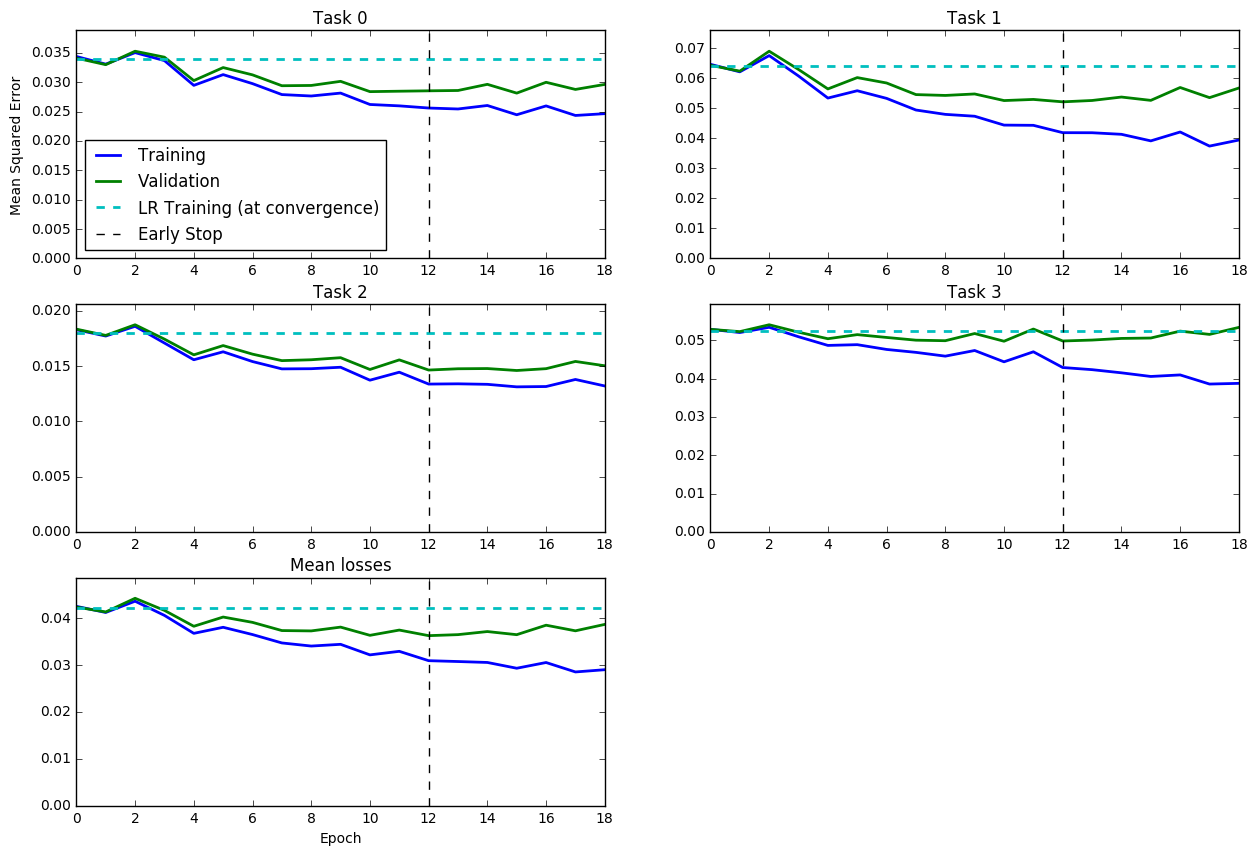

In [29]:
metric = "Mean Squared Error"
print_perf(model, metric)

In [30]:
def plot_sequence_filters(dnn):
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    conv_filters = dnn.get_sequence_filters()
    num_plots_per_axis = int(len(conv_filters)**0.5) + 1
    for i, conv_filter in enumerate(conv_filters):
        ax = fig.add_subplot(num_plots_per_axis, num_plots_per_axis, i+1)
        add_letters_to_axis(ax, conv_filter.T)
        ax.axis("off")
        ax.set_title("Filter %s" % (str(i+1)))
    plt.savefig("filters.png")
    plt.show()

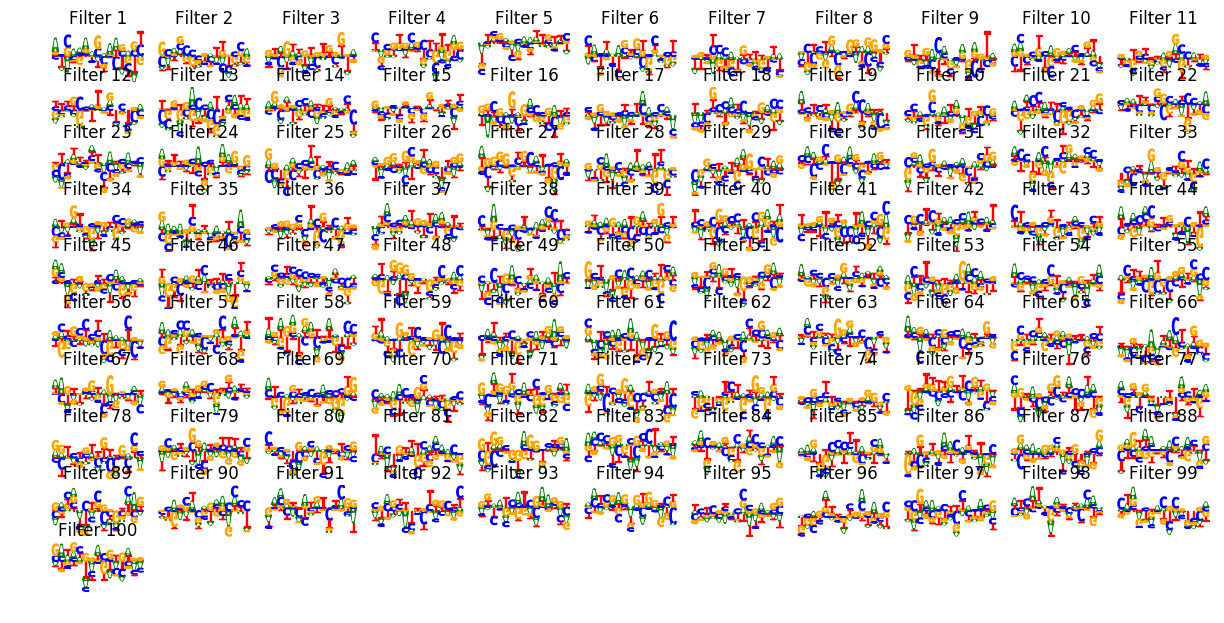

In [31]:
plot_sequence_filters(model)

In [34]:
model.plot_in_silico_mutagenesis(X[:10, :, :, :], "ism")

In [9]:
model.plot_deeplift(X[:10, :, :, :], "deeplift")